In [2]:
import math
from pathlib import Path
from typing import Dict, Tuple
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from openpyxl import load_workbook

from stable_baselines3 import PPO
from src.environment.data_loader import load_time_series_csv, load_all_exposures, trading_days_from_prices
from src.environment.environment import InvestorProfile
from src.environment.calendar_engine import build_master_calendar
from src.agent.env_gym_wrapper import PortfolioGymWrapper
from src.utils.config_file import configYaml
from src.environment.data_loader import precompute_indicators



### 0. AJUSTAR PERFIL Y PERIODO

In [3]:

plt.style.use("seaborn-v0_8")

MODEL_ZIP = configYaml.paths.model_zip
OUT_DIR = Path(getattr(configYaml.paths, "reports", "reports")) / "2022_2025_eval_notebook"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DATE_START = pd.Timestamp("2022-09-01")
DATE_END   = pd.Timestamp("2025-09-01")

PROFILE = InvestorProfile(
    riesgo=4,
    horizonte_anios=3,
    aportacion_mensual_usd=1000,
    liquidez_inicial_usd=10_000.0
)


### 1. MÉTRICAS, UTILIDADES Y CARGA DE DATOS

In [4]:
# ---------- MÉTRICAS ----------
def annual_rent(nav: pd.Series) -> float:
    if nav.empty or nav.iloc[0] <= 0: return 0.0
    yrs = (nav.index[-1] - nav.index[0]).days / 365.25
    if yrs <= 0: return 0.0
    return (nav.iloc[-1] / nav.iloc[0]) ** (1 / yrs) - 1

def annual_volatility(rets: pd.Series, freq: int = 252) -> float:
    r = rets.dropna()
    return float(r.std(ddof=1)) * np.sqrt(freq) if len(r) > 1 else 0.0

def sharpe(rets: pd.Series, rf: float = 0.0, freq: int = 252) -> float:
    vol = annual_volatility(rets, freq)
    if vol == 0: return 0.0
    return (rets.mean() * freq - rf) / vol

def max_dd(nav: pd.Series) -> float:
    if nav.empty: return 0.0
    peak = nav.cummax()
    return float((nav / peak - 1.0).min())


# ---------- RESUMEN DE RESULTADOS ----------
def summarize(name: str, nav: pd.Series, rets: pd.Series, turnover: float = 0.0) -> Dict:
    """Devuelve métricas clave para cualquier curva de rendimiento."""
    return {
        "Estrategia": name,
        "Rentabilidad Anual (%)": annual_rent(nav) * 100.0,
        "Acumulado (%)": ((nav.iloc[-1] / nav.iloc[0] - 1) * 100.0),
        "Volatilidad Anual": annual_volatility(rets),
        "Sharpe": sharpe(rets),
        "Máx. caída": max_dd(nav),
        "Rotación Anual": turnover,
    }


# ---------- CARGA DE DATOS ----------
def load_market() -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Carga precios, AUM y exposiciones desde los paths definidos en configYaml
    """
    prices, aum, _ = load_time_series_csv(configYaml.paths.time_series)
    exposures = load_all_exposures(
        configYaml.paths.exposures_country,
        configYaml.paths.exposures_sector,
        prices
    )

    idx = build_master_calendar(trading_days_from_prices(prices))
    prices = prices.reindex(idx).ffill()
    aum = aum.reindex(idx).ffill()

    prices = prices.loc[DATE_START:DATE_END]
    aum = aum.loc[DATE_START:DATE_END]
    return prices, aum, exposures


### 2. EVALUACION PPO + CACHEAR RESULTADOS

In [21]:
def run_model_inference(prices: pd.DataFrame, aum: pd.DataFrame, exposures: Dict):
    """
    Ejecuta el modelo PPO sobre el periodo seleccionado y devuelve:
      - nav_curve (NAV/TWR acumulado)
      - rets (rentabilidades diarias)
      - wealth_curve (patrimonio total)
      - turnover (rotación anual estimada)
    """
    # Reutiliza los mismos indicadores usados durante el entrenamiento
    indicators = precompute_indicators(prices)

    sampler_fijo = lambda: PROFILE

    # Crear entorno idéntico al de entrenamiento
    env = PortfolioGymWrapper(
        prices=prices,
        aum=aum,
        exposures=exposures,
        sampler=sampler_fijo,
        indicators=indicators,
        start_date_limit=prices.index[0],
        end_date_limit=prices.index[-1],
    )

    # Cargar el modelo PPO entrenado
    model = PPO.load(MODEL_ZIP, device="cpu")

    # Simulación determinista sobre el periodo completo
    obs, _ = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)

    # Historial de ejecución
    hist = pd.DataFrame(env.core.history).sort_values("fecha")

    # Rentabilidades diarias
    rets = pd.Series(
        [float(x) for x in hist["rentabilidad_diaria(%)"].values],
        index=pd.to_datetime(hist["fecha"].values),
        dtype=float,
    ).reindex(prices.index).fillna(0.0) / 100.0

    # NAV
    nav_curve = (1.0 + rets).cumprod() * PROFILE.liquidez_inicial_usd
    nav_curve.name = "nav"

    # Patrimonio total (wealth)
    wealth_curve = pd.Series(
        hist["valor_cartera"].values,
        index=pd.to_datetime(hist["fecha"].values),
        name="wealth",
    ).reindex(prices.index).ffill()

    # Cálculo de rotación anual estimada
    def turnover_from_history(history: list[dict], universe: list[str]) -> float:
        if not history:
            return 0.0
        records = []
        for row in history:
            d = pd.to_datetime(row.get("fecha"))
            pos = row.get("posiciones(%)", {}) or {}
            w = {t: float(pos.get(t, 0.0)) / 100.0 for t in universe}
            s = sum(w.values())
            if s > 0:
                w = {t: v / s for t, v in w.items()}
            records.append(pd.Series(w, name=d))
        W = pd.DataFrame(records).sort_index().fillna(0.0)
        if W.shape[0] < 2:
            return 0.0
        daily_turn = W.diff().abs().sum(axis=1).dropna()
        mean_daily = float(daily_turn.mean()) if len(daily_turn) else 0.0
        return mean_daily * 252.0

    turnover = turnover_from_history(env.core.history, env.core.universe)
    return nav_curve, rets, wealth_curve, turnover


# ---------- EJECUCIÓN DEL MODELO ----------
prices, aum, exposures = load_market()
nav_model, rets_model, wealth_model, turnover_model = run_model_inference(prices, aum, exposures)
print("✅ Evaluación PPO completada correctamente para el periodo", {prices.index[0].date()}, "→" ,{prices.index[-1].date()})


✅ Evaluación PPO completada correctamente para el periodo {prices.index[0].date()} → {prices.index[-1].date()}


In [22]:
# Columnas estándar de resultados
RESULTS_COLUMNS = [
    "Estrategia",
    "Rentabilidad Anual (%)",
    "Acumulado (%)",
    "Volatilidad Anual",
    "Sharpe",
    "Máx. Drawdown",
    "Rotación Anual",
]

# Periodo evaluado
EVAL_PERIOD = (prices.index[0].date(), prices.index[-1].date())

# Almacén global de estrategias ya calculadas (series + métricas)
STRATEGIE_STORE = {}

def make_summary_row(name: str, nav: pd.Series, rets: pd.Series, turnover: float) -> dict:
    return {
        "Estrategia": name,
        "Rentabilidad Anual (%)": annual_rent(nav) * 100.0,
        "Acumulado (%)": (nav.iloc[-1] / nav.iloc[0] - 1.0) * 100.0,
        "Volatilidad Anual": annual_volatility(rets),
        "Sharpe": sharpe(rets),
        "Máx. Drawdown": max_dd(nav),
        "Rotación Anual": turnover,
    }

def register_strategy(name: str, nav: pd.Series, rets: pd.Series, turnover: float):
    """Registra/actualiza una estrategia en memoria (series y métricas)"""
    STRATEGIE_STORE[name] = {
        "nav": nav,
        "rets": rets,
        "turnover": turnover,
        "metrics": make_summary_row(name, nav, rets, turnover),
    }

def get_results_table(names: list[str] | None = None) -> pd.DataFrame:
    """
    Devuelve un DataFrame con las métricas de las estrategias indicadas.
    Si names es None, usa todas las registradas hasta el momento.
    """
    keys = names if names is not None else list(STRATEGIE_STORE.keys())
    rows = [STRATEGIE_STORE[k]["metrics"] for k in keys if k in STRATEGIE_STORE]
    if not rows:
        return pd.DataFrame(columns=RESULTS_COLUMNS)
    df = pd.DataFrame(rows)[RESULTS_COLUMNS]
    return df

register_strategy("PPO_INV", nav_model, rets_model, turnover_model)
ppo_table = get_results_table(["PPO_INV"])
display(ppo_table.round(4))


,Estrategia,Rentabilidad Anual (%),Acumulado (%),Volatilidad Anual,Sharpe,Máx. Drawdown,Rotación Anual
0,PPO_INV,5.2745,16.6277,0.138,0.4434,-0.1565,65.511


### 3. GRAFICO PPO_INV VS BENCHMARK

,Estrategia,Rentabilidad Anual (%),Acumulado (%),Volatilidad Anual,Sharpe,Máx. Drawdown,Rotación Anual
0,PPO_INV,5.2745,16.6277,0.1380,0.4434,-0.1565,65.511
1,Benchmark,11.4123,38.1804,0.1292,0.9056,-0.1281,0.000


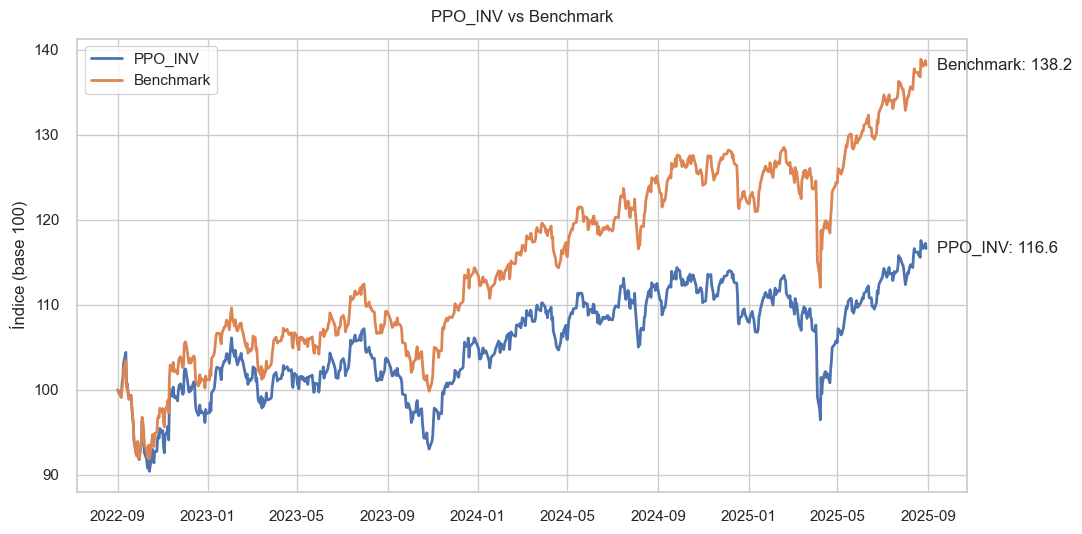

In [7]:
def _prep_nav100(s: pd.Series, name: str) -> pd.Series:
    s = (s / s.iloc[0]) * 100.0 if s.iloc[0] != 0 else s * 0.0
    s.name = name
    return s

bench_rets = prices.pct_change().fillna(0.0).mean(axis=1)
bench_nav100 = (1.0 + bench_rets).cumprod() * 100.0
bench_nav100.name = "Benchmark"
# Registra la nueva estrategia en el strategie_store
register_strategy("Benchmark", bench_nav100, bench_rets, turnover=0.0)

ppo_nav100 = _prep_nav100(nav_model, "PPO_INV")

# --- Tabla Métricas (PPO_INV + Benchmark) ---
results_table_pb = get_results_table(["PPO_INV", "Benchmark"])
display(results_table_pb.round(4))

# --- Gráfico Seaborn ---
df_plot = pd.concat([ppo_nav100, bench_nav100], axis=1).dropna()
df_plot = df_plot.rename_axis("Fecha").reset_index().melt("Fecha", var_name="Estrategia", value_name="Índice")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(11, 5.5))
ax = sns.lineplot(data=df_plot, x="Fecha", y="Índice", hue="Estrategia", linewidth=2)
ax.set_title("PPO_INV vs Benchmark", pad=12)
ax.set_xlabel("")
ax.set_ylabel("Índice (base 100)")
ax.legend(title="", frameon=True)

# Anotación del valor final de cada curva
last_vals = df_plot.sort_values("Fecha").groupby("Estrategia").tail(1)
for _, row in last_vals.iterrows():
    ax.annotate(f"{row['Estrategia']}: {row['Índice']:.1f}",
                xy=(row["Fecha"], row["Índice"]),
                xytext=(8, 0), textcoords="offset points",
                va="center")

plt.tight_layout()
plt.savefig(OUT_DIR / "ppo_vs_benchmark.png", dpi=160)
plt.show()


### 4. GRAFICO PPO_INV VS 60/40 & Markowitz

,Estrategia,Rentabilidad Anual (%),Acumulado (%),Volatilidad Anual,Sharpe,Máx. Drawdown,Rotación Anual
0,PPO_INV,5.2745,16.6277,0.1380,0.4434,-0.1565,65.5110
1,Balanced Portfolio (60/40),8.2683,26.8365,0.0995,0.8522,-0.0998,0.3333
2,Mean-Variance (Markowitz),6.9993,22.4396,0.1353,0.5704,-0.1394,5.7071


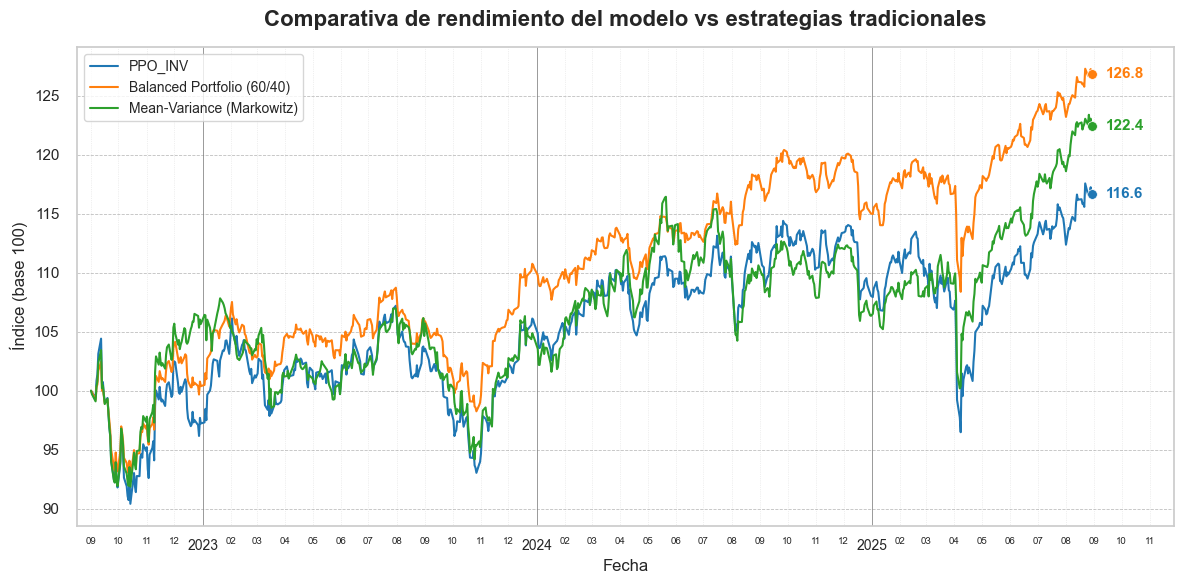

In [8]:
def _first_business_days(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    from src.environment.calendar_engine import monthly_contribution_mask
    mask = monthly_contribution_mask(idx)
    return mask[mask.values].index

def _monthly_targets_6040(prices: pd.DataFrame, exposures: dict) -> dict:
    tipos = exposures.get("type_sector", {})
    universe = list(prices.columns)
    eq = [t for t in universe if tipos.get(t) == "Equity"] or universe[: max(1, len(universe)//2)]
    fi = [t for t in universe if tipos.get(t) == "FixedIncome"] or universe[max(1, len(universe)//2):]
    W = {}
    for d in _first_business_days(prices.index):
        we = {t: 0.6/len(eq) for t in eq}
        wb = {t: 0.4/len(fi) for t in fi}
        w  = {**{t:0.0 for t in universe}, **we, **wb}
        W[pd.Timestamp(d)] = w
    return W

# ---------- Markowitz rolling (media-varianza) ----------
def _lw_shrinkage_cov(returns: pd.DataFrame, shrink: float = 0.1) -> np.ndarray:
    S = returns.cov().values
    var = np.trace(S)/S.shape[0]
    F = var * np.eye(S.shape[0])
    return (1 - shrink) * S + shrink * F

def _markowitz_weights(mu: np.ndarray, cov: np.ndarray, wmax: float = 0.25) -> np.ndarray:
    try:
        import scipy.optimize as spo
        n = len(mu)
        def neg_sharpe(w):
            r = w @ mu
            v = math.sqrt(max(1e-12, w @ cov @ w))
            return -r / v
        cons = [{"type":"eq","fun":lambda w: np.sum(w) - 1.0}]
        bnds = [(0.0, wmax)]*n
        x0 = np.ones(n)/n
        res = spo.minimize(neg_sharpe, x0, method="SLSQP", bounds=bnds, constraints=cons, options={"maxiter":200})
        w = res.x if res.success else x0
    except Exception:
        w = np.ones_like(mu) / len(mu)
    w = np.clip(w, 0, wmax)
    s = w.sum()
    return w/s if s>0 else np.ones_like(mu)/len(mu)

def _build_markowitz_schedule(prices: pd.DataFrame, lookback_days: int = 756, wmax: float = 0.25) -> dict:
    rebal_days = _first_business_days(prices.index)
    W = {}
    for d in rebal_days:
        hist = prices.loc[:d].tail(lookback_days+1).pct_change().dropna()
        if hist.shape[0] < 60 or hist.shape[1] < 2:
            w = np.ones(max(1, hist.shape[1])) / max(1, hist.shape[1])
            cols = hist.columns if hist.shape[1] > 0 else prices.columns
        else:
            mu  = hist.mean().values * 252.0
            cov = _lw_shrinkage_cov(hist, shrink=0.1)
            w   = _markowitz_weights(mu, cov, wmax=wmax)
            cols = hist.columns
        W[pd.Timestamp(d)] = {t: float(w[i]) for i, t in enumerate(cols)}
    return W

# ---------- Backtest TWR simple (sin aportaciones) ----------
def _run_backtest_twr(prices: pd.DataFrame, schedule: dict):
    idx = prices.index
    rets_px = prices.pct_change().fillna(0.0)
    universe = list(prices.columns)
    w_curr = {t:0.0 for t in universe}
    port_rets = []
    turnovers = []
    prev_w = w_curr.copy()

    for d in idx:
        if d in schedule:
            # normaliza y alinea a universo
            target = {t: max(0.0, float(schedule[d].get(t, 0.0))) for t in universe}
            s = sum(target.values())
            w_curr = {t: (v/s if s>0 else 0.0) for t, v in target.items()}
            # turnover en día de rebalanceo
            turnovers.append(sum(abs(w_curr.get(t,0)-prev_w.get(t,0)) for t in universe))
            prev_w = w_curr.copy()

        r_d = float(sum(w_curr.get(t,0.0) * rets_px.loc[d].get(t,0.0) for t in universe))
        port_rets.append(r_d)

    rets = pd.Series(port_rets, index=idx, name="ret")
    nav  = (1.0 + rets).cumprod()
    nav.name = "nav"
    turn_yr = (np.mean(turnovers) * 12.0) if turnovers else 0.0
    return nav, rets, turn_yr

# ---------- 60/40 y Markowitz----------
sched_6040 = _monthly_targets_6040(prices, exposures)
nav_6040, rets_6040, to_6040 = _run_backtest_twr(prices, sched_6040)
register_strategy("Balanced Portfolio (60/40)", nav_6040, rets_6040, to_6040)

sched_mkv = _build_markowitz_schedule(prices, lookback_days=756, wmax=0.25)
nav_mkv, rets_mkv, to_mkv = _run_backtest_twr(prices, sched_mkv)
register_strategy("Mean-Variance (Markowitz)", nav_mkv, rets_mkv, to_mkv)

# Tabla Métricas (PPO_INV + 60/40 + MKV)
results_table_cmp = get_results_table(["PPO_INV", "Balanced Portfolio (60/40)", "Mean-Variance (Markowitz)"])
display(results_table_cmp.round(4))
results_table_cmp.to_csv(OUT_DIR / "metrics_ppo_vs_tradi.csv")


def _nav_base100(s: pd.Series, name: str) -> pd.Series:
    out = (s / s.iloc[0]) * 100.0 if s.iloc[0] != 0 else s*0.0
    out.name = name
    return out

ppo_nav100 = _nav_base100(STRATEGIE_STORE["PPO_INV"]["nav"], "PPO_INV")
nav6040_100 = _nav_base100(nav_6040, "Balanced Portfolio (60/40)")
navmkv_100  = _nav_base100(nav_mkv,  "Mean-Variance (Markowitz)")

df_plot = pd.concat([ppo_nav100, nav6040_100, navmkv_100], axis=1).dropna()
df_plot = df_plot.rename_axis("Fecha").reset_index().melt("Fecha", var_name="Estrategia", value_name="Índice")

# ---------- Gráfico comparativo ----------
# Definir paleta de colores y estilos de línea profesionales
palette = {
    "PPO_INV": "tab:blue",
    "Balanced Portfolio (60/40)": "tab:orange",
    "Mean-Variance (Markowitz)": "tab:green"
}

# Configurar el tema y la figura
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Crear el gráfico principal
ax = sns.lineplot(
    data=df_plot,
    x="Fecha",
    y="Índice",
    hue="Estrategia",
    palette=palette,
    linewidth=1.5
)

# Títulos y etiquetas descriptivos
ax.set_title("Comparativa de rendimiento del modelo vs estrategias tradicionales", fontsize=16, pad=15, weight='bold')
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Índice (base 100)", fontsize=12)

# Mover la leyenda para evitar solapamiento
ax.legend(loc='upper left', frameon=True, title="", fontsize=10)

# 7. Formato de Eje X
# Major ticks (Años)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# Minor ticks (Meses)
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(2, 13)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

# Ajustar el padding y tamaño de las etiquetas
ax.tick_params(axis='x', which='major', pad=4, labelsize=10)
ax.tick_params(axis='x', which='minor', pad=4, labelsize=7)

# 8. Personalizar la rejilla
# Rejilla horizontal (eje Y)
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
# Rejilla vertical (eje X)
ax.grid(True, which='major', axis='x', linestyle='-', linewidth=0.7, color='grey', alpha=0.8)
ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, color='lightgrey', alpha=0.7)


# 9. Ajustar límites del eje X
date_min = df_plot["Fecha"].min()
date_max = df_plot["Fecha"].max()
ax.set_xlim(date_min - pd.Timedelta(days=15), date_max + pd.Timedelta(days=90))

# 10. Anotar valores finales
last_vals = df_plot.sort_values("Fecha").groupby("Estrategia").tail(1)
for _, row in last_vals.iterrows():
    strategy_name = row['Estrategia']
    final_value = row['Índice']
    final_date = row['Fecha']
    color = palette[strategy_name]

    ax.plot(final_date, final_value, 'o', color=color, markersize=7, markeredgecolor='white', markeredgewidth=0.5)
    ax.annotate(
        f"{final_value:.1f}",
        xy=(final_date, final_value),
        xytext=(10, 0),
        textcoords="offset points",
        va="center",
        ha="left",
        fontsize=11,
        fontweight='bold',
        color=color
    )

# 11. Limpieza final y guardado
plt.tight_layout()
plt.savefig(OUT_DIR / "ppo_vs_6040_mkv_enhanced_v2.png", dpi=200)
plt.show()


### 5. MOVIMIENTOS ROBOADVISOR PPO

In [23]:
W = STRATEGIE_STORE["PPO_INV"]["positions"]     # pesos por fecha (0–1)
V = STRATEGIE_STORE["PPO_INV"]["wealth"]        # patrimonio por fecha
px = prices.astype(float)                       # precios

# Etiqueta “Nombre (Ticker)”
def _long_name_label(ticker: str) -> str:
    name_map = {}
    if isinstance(exposures, dict):
        for k in ("long_name", "name", "etf_name", "fund_name"):
            m = exposures.get(k)
            if isinstance(m, dict):
                name_map = m; break
    base = name_map.get(ticker, ticker)
    return f"{base} ({ticker})" if base else f"{ticker} ({ticker})"

# Trades ajustados por mercado + aportaciones
def build_trades_market_adjusted(W: pd.DataFrame, V: pd.Series, prices: pd.DataFrame,
                                 min_notional_usd: float = 1e-4) -> pd.DataFrame:
    W = W.reindex(prices.index).fillna(0.0)
    V = V.reindex(prices.index).ffill()
    px = prices.astype(float)

    target_val   = W.mul(V, axis=0)
    px_ratio     = (px / px.shift(1)).replace([np.inf,-np.inf], np.nan).fillna(1.0)
    prev_val_mkt = (W.shift(1).fillna(0.0)).mul(V.shift(1).fillna(0.0), axis=0).mul(px_ratio, axis=0)
    trade_val    = (target_val - prev_val_mkt).fillna(0.0)
    qty          = (trade_val / px).replace([np.inf,-np.inf], np.nan).fillna(0.0)
    dw           = W.diff().fillna(0.0)

    df = pd.concat({
        "Importe USD": trade_val.stack(),
        "Cantidad":    qty.stack(),
        "ΔPeso":       dw.stack(),
        "Peso final":  W.stack()
    }, axis=1).reset_index()
    df.columns = ["Fecha", "Ticker", "Importe USD", "Cantidad", "ΔPeso", "Peso final"]
    df = df.loc[df["Importe USD"].abs() > min_notional_usd].copy()
    df["Acción"]   = np.where(df["Cantidad"] > 0, "Compra", "Venta")
    df["Precio"]   = df.apply(lambda r: float(prices.loc[r["Fecha"], r["Ticker"]]), axis=1)
    df["Peso (%)"] = df["Peso final"] * 100.0
    df["Fondo"]    = df["Ticker"].apply(_long_name_label)
    df = df[["Fecha","Fondo","Ticker","Acción","Cantidad","Precio","Importe USD","ΔPeso","Peso (%)"]]
    df = df.sort_values(["Fecha","Fondo"]).reset_index(drop=True)
    return df

trades_df = build_trades_market_adjusted(W, V, px)

# Cartera final (tabla)
last_day   = W.index[-1]
w_last     = W.loc[last_day].astype(float)
w_last     = w_last[w_last > 0]
px_last    = px.loc[last_day]
wealth_last= float(V.loc[last_day])
val_last   = (w_last * wealth_last)
units_last = (val_last / px_last[w_last.index]).replace([np.inf,-np.inf], np.nan).fillna(0.0)

cartera_final = pd.DataFrame({
    "Ticker":   w_last.index,
    "Fondo":    [ _long_name_label(t) for t in w_last.index ],
    "Peso (%)": w_last.values * 100.0,
    "Unidades": units_last.values,
    "Precio":   px_last[w_last.index].values,
    "Valor USD":val_last.values
}).sort_values("Valor USD", ascending=False).reset_index(drop=True)

# Métricas de concentración de la cartera final
weights = (w_last / w_last.sum()).sort_values(ascending=False)
hhi   = float((weights**2).sum())
enp   = 1.0/hhi if hhi > 0 else np.nan
top5  = float(weights.head(5).sum()*100.0)
top10 = float(weights.head(10).sum()*100.0)
metrics_final = pd.DataFrame([{
    "Fecha": last_day.date(),
    "Nº posiciones": int((weights>0).sum()),
    "HHI": hhi,
    "ENP (1/HHI)": enp,
    "Top-5 (%)": top5,
    "Top-10 (%)": top10,
    "Peso medio (%)": float(weights.mean()*100.0),
    "Peso máx (%)":   float(weights.max()*100.0),
    "Peso mín >0 (%)":float(weights[weights>0].min()*100.0),
}])

# Guardar excel
xlsx_path = OUT_DIR / "ppo_movimientos_cartera.xlsx"

# Escribir las hojas con motor por defecto
with pd.ExcelWriter(xlsx_path) as writer:
    trades_df.to_excel(writer, sheet_name="Movimientos", index=False)
    cartera_final.to_excel(writer, sheet_name="Cartera_Final", index=False)
    metrics_final.to_excel(writer, sheet_name="Metricas_Cartera", index=False)
# Formatear con openpyxl
wb = load_workbook(xlsx_path)

def _fmt_sheet(ws, df):
    # Autofiltro sobre to el rango con datos
    max_row = max(1, ws.max_row)
    max_col = ws.max_column
    ws.auto_filter.ref = ws.dimensions
    # Congelar primera fila
    ws.freeze_panes = "A2"
    # Ajustar anchos de columna
    for i, col in enumerate(df.columns, start=1):
        # ancho heurístico según longitud de texto típica
        width = min(60, max(12, int(df[col].astype(str).str.len().quantile(0.9)) + 2))
        ws.column_dimensions[ws.cell(row=1, column=i).column_letter].width = width

_fmt_sheet(wb["Movimientos"], trades_df)
_fmt_sheet(wb["Cartera_Final"], cartera_final)
_fmt_sheet(wb["Metricas_Cartera"], metrics_final)

wb.save(xlsx_path)
wb.close()

# 6) Guardar imagen de la cartera final
sns.set_theme(style="white", context="talk")
fig = plt.figure(figsize=(11, 6), facecolor="white")
ax = sns.barplot(
    data=cartera_final.sort_values("Peso (%)", ascending=True),
    x="Peso (%)", y="Fondo", orient="h"
)
ax.set_title(f"Cartera final — {last_day.date()}", pad=12)
ax.set_xlabel("Peso (%)"); ax.set_ylabel("")
ax.grid(axis="x", color="#e6e6e6")
ax.set_facecolor("white")
plt.tight_layout()
img_path = OUT_DIR / "ppo_cartera_final.png"
plt.savefig(img_path, dpi=160, facecolor="white", transparent=False)
plt.close(fig)

print(f"Imagen de cartera final guardada: {img_path}")


KeyError: 'positions'

### PPO_INV VS INDEXA CAPITAL

,Estrategia,Rentabilidad Anual (%),Acumulado (%),Volatilidad Anual,Sharpe,Máx. Drawdown,Rotación Anual
0,PPO_INV,5.2745,16.6277,0.1380,0.4434,-0.1565,65.511
1,INDEXA_CAPITAL,6.7047,21.4983,0.0607,0.7669,-0.1040,0.000


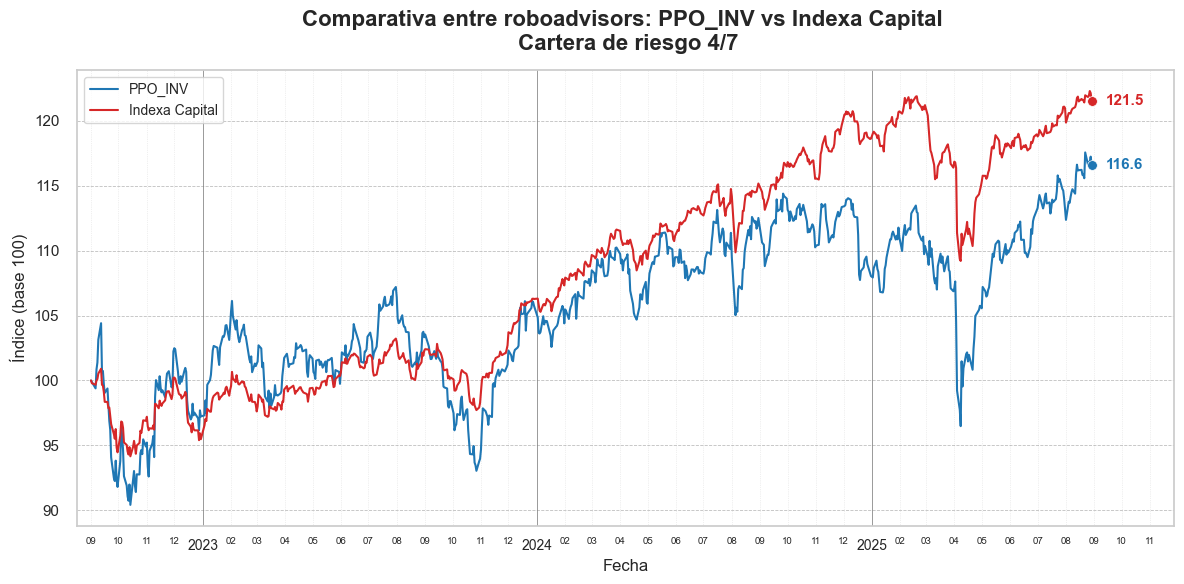

In [13]:
# =========================================================
# PPO_INV vs INDEXA Capital (Riesgo 4): tabla de métricas + gráfico comparativo
# Requiere: STRATEGIE_STORE, RESULTS_COLUMNS, register_strategy, get_results_table,
#           nav_model (cache PPO), prices (para límites de fechas), OUT_DIR
# =========================================================
# Cargar CSV de Indexa Capital (perfil 4)
indexa_path = configYaml.paths.indexa_capital
df_idx = pd.read_csv(
    indexa_path,
    sep=";", decimal=",",
    parse_dates=["fecha"], dayfirst=True,
    dtype={"result": "float64"}
)

# Serie NAV Indexa (alineada al índice temporal)
indexa_nav_raw = pd.Series(df_idx["result"].values, index=df_idx["fecha"].values, name="INDEXA_CAPITAL").sort_index()
# Normalizar a base 100 para el gráfico
indexa_nav100 = (indexa_nav_raw / indexa_nav_raw.iloc[0]) * 100.0
# Retornos diarios para métricas
indexa_rets   = indexa_nav_raw.pct_change().fillna(0.0)

# Registrar en el store global
register_strategy("INDEXA_CAPITAL", indexa_nav_raw, indexa_rets, turnover=0.0)

# Tabla de métricas
results_table_ix = get_results_table(["PPO_INV", "INDEXA_CAPITAL"])
display(results_table_ix.round(4))

# Preparar DataFrame para gráfico (base 100, mismas fechas solapadas)
ppo_nav100 = (nav_model / nav_model.iloc[0]) * 100.0
df_plot = pd.concat([
    ppo_nav100.rename("PPO_INV"),
    indexa_nav100.rename("Indexa Capital")
], axis=1).dropna()
df_plot = df_plot.rename_axis("Fecha").reset_index().melt("Fecha", var_name="Estrategia", value_name="Índice")

# Estilo visual
palette = {
    "PPO_INV": "tab:blue",
    "Indexa Capital": "tab:red",
}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6), facecolor="white")

ax = sns.lineplot(
    data=df_plot,
    x="Fecha",
    y="Índice",
    hue="Estrategia",
    palette=palette,
    linewidth=1.5
)
ax.set_facecolor("white")

# Títulos y ejes
ax.set_title("Comparativa entre roboadvisors: PPO_INV vs Indexa Capital \n Cartera de riesgo 4/7", fontsize=16, pad=15, weight='bold')
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Índice (base 100)", fontsize=12)

# Leyenda
ax.legend(loc='upper left', frameon=True, title="", fontsize=10)

# Formato del eje X (Años mayor / Meses menor)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(2, 13)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
ax.tick_params(axis='x', which='major', pad=4, labelsize=10)
ax.tick_params(axis='x', which='minor', pad=4, labelsize=7)

# Rejilla Y (horizontal) y X (vertical mayor/menor)
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax.grid(True, which='major', axis='x', linestyle='-',  linewidth=0.7, color='grey', alpha=0.8)
ax.grid(True, which='minor', axis='x', linestyle=':',  linewidth=0.5, color='lightgrey', alpha=0.7)

# Límites del eje X basados en el rango del DataFrame
date_min = df_plot["Fecha"].min()
date_max = df_plot["Fecha"].max()
ax.set_xlim(date_min - pd.Timedelta(days=15), date_max + pd.Timedelta(days=90))

# Anotación de valores finales
last_vals = df_plot.sort_values("Fecha").groupby("Estrategia").tail(1)
for _, row in last_vals.iterrows():
    nm = row['Estrategia']
    val = row['Índice']
    dt  = row['Fecha']
    color = palette[nm]
    ax.plot(dt, val, 'o', color=color, markersize=7, markeredgecolor='white', markeredgewidth=0.5)
    ax.annotate(
        f"{val:.1f}",
        xy=(dt, val),
        xytext=(10, 0),
        textcoords="offset points",
        va="center",
        ha="left",
        fontsize=11,
        fontweight='bold',
        color=color
    )

plt.tight_layout()
plt.savefig(OUT_DIR / "ppo_vs_indexa_r4.png", dpi=200, facecolor="white", transparent=False)
plt.show()


### Diversificacion por sectores y paises

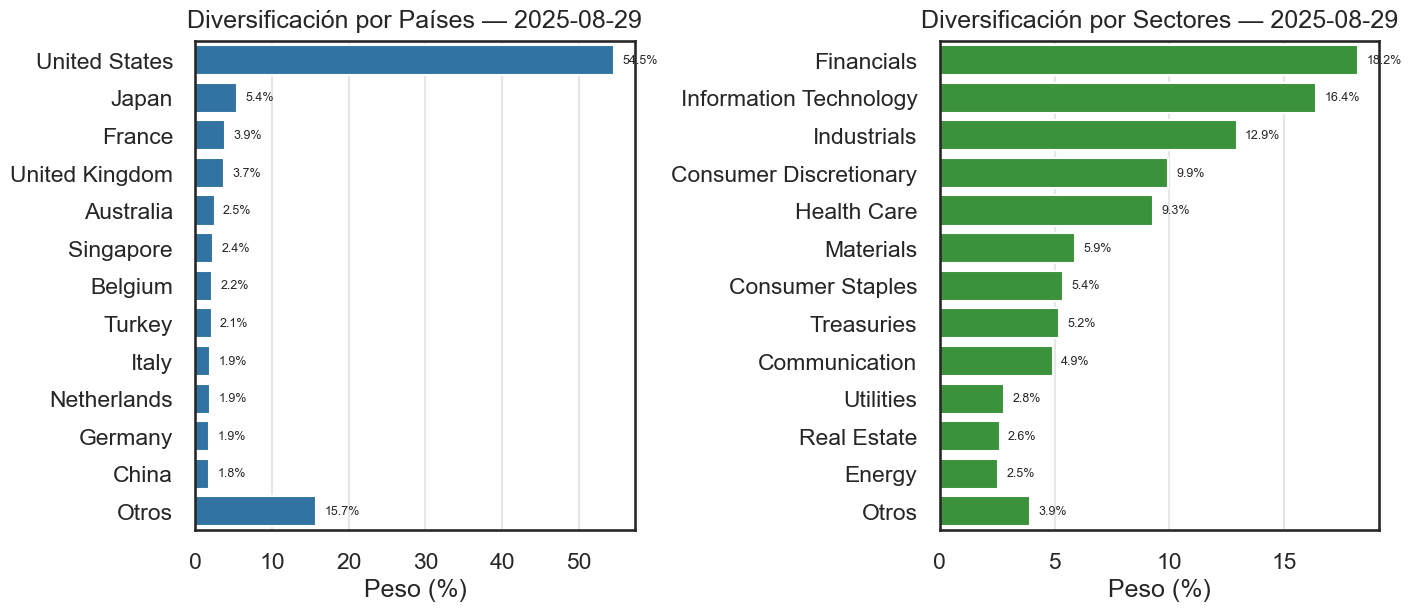

✅ Diversificación generada correctamente y guardada en: reports\2022_2025_eval_notebook\ppo_diversificacion_paises_sectores.png


In [25]:

# Construir distribuciones usando estructura real de exposures

def _aggregate_exposure(exposure_dict: dict, w_last: pd.Series, key_label: str) -> pd.Series:
    """
    Suma ponderada de exposiciones por país o sector:
      exposure_dict[ticker] = DataFrame con columnas [key_label, 'weight']
    """
    totals = {}
    for ticker, w in w_last.items():
        df = exposure_dict.get(ticker)
        if df is None or df.empty:
            continue
        df = df.dropna(subset=[key_label, "weight"])
        for _, row in df.iterrows():
            k = str(row[key_label]).strip()
            val = float(row["weight"]) * w
            totals[k] = totals.get(k, 0.0) + val
    s = pd.Series(totals).sort_values(ascending=False)
    s /= s.sum() if s.sum() > 0 else 1.0
    return s

# Calcular distribuciones ponderadas reales
country_dist = _aggregate_exposure(exposures["country_by_ticker"], w_last, "country")
sector_dist  = _aggregate_exposure(exposures["sector_by_ticker"],  w_last, "sector")

# Top N + "Otros"
TOP_N = 12
def _top_with_others(s: pd.Series, top_n: int) -> pd.Series:
    if len(s) <= top_n:
        return s * 100.0
    top = s.iloc[:top_n]
    otros = pd.Series({"Otros": s.iloc[top_n:].sum()})
    return pd.concat([top, otros]) * 100.0

country_plot = _top_with_others(country_dist, TOP_N)
sector_plot  = _top_with_others(sector_dist,  TOP_N)

# Gráfico
sns.set_theme(style="white", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor="white", constrained_layout=True)

# Países
ax0 = axes[0]
sns.barplot(x=country_plot.values, y=country_plot.index, ax=ax0, orient="h", color="tab:blue")
ax0.set_title(f"Diversificación por Países — {last_day.date()}", pad=10)
ax0.set_xlabel("Peso (%)"); ax0.set_ylabel("")
ax0.grid(axis="x", color="#e6e6e6")
ax0.set_facecolor("white")

# Sectores
ax1 = axes[1]
sns.barplot(x=sector_plot.values, y=sector_plot.index, ax=ax1, orient="h", color="tab:green")
ax1.set_title(f"Diversificación por Sectores — {last_day.date()}", pad=10)
ax1.set_xlabel("Peso (%)"); ax1.set_ylabel("")
ax1.grid(axis="x", color="#e6e6e6")
ax1.set_facecolor("white")

# Etiquetas %
for ax in (ax0, ax1):
    for p in ax.patches:
        val = p.get_width()
        if val >= 0.1:
            ax.annotate(f"{val:.1f}%",
                        (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2),
                        xytext=(6, 0), textcoords="offset points",
                        va="center", ha="left", fontsize=9)

out_path = OUT_DIR / "ppo_diversificacion_paises_sectores.png"
plt.savefig(out_path, dpi=180, facecolor="white", transparent=False)
plt.show()


### Heatmap de pesos: Visualizar como toma decisiones el agente a lo largo del tiempo

C:\Users\alons\AppData\Local\Temp\ipykernel_8980\1311210670.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Wp_m = Wp.resample("M").mean()


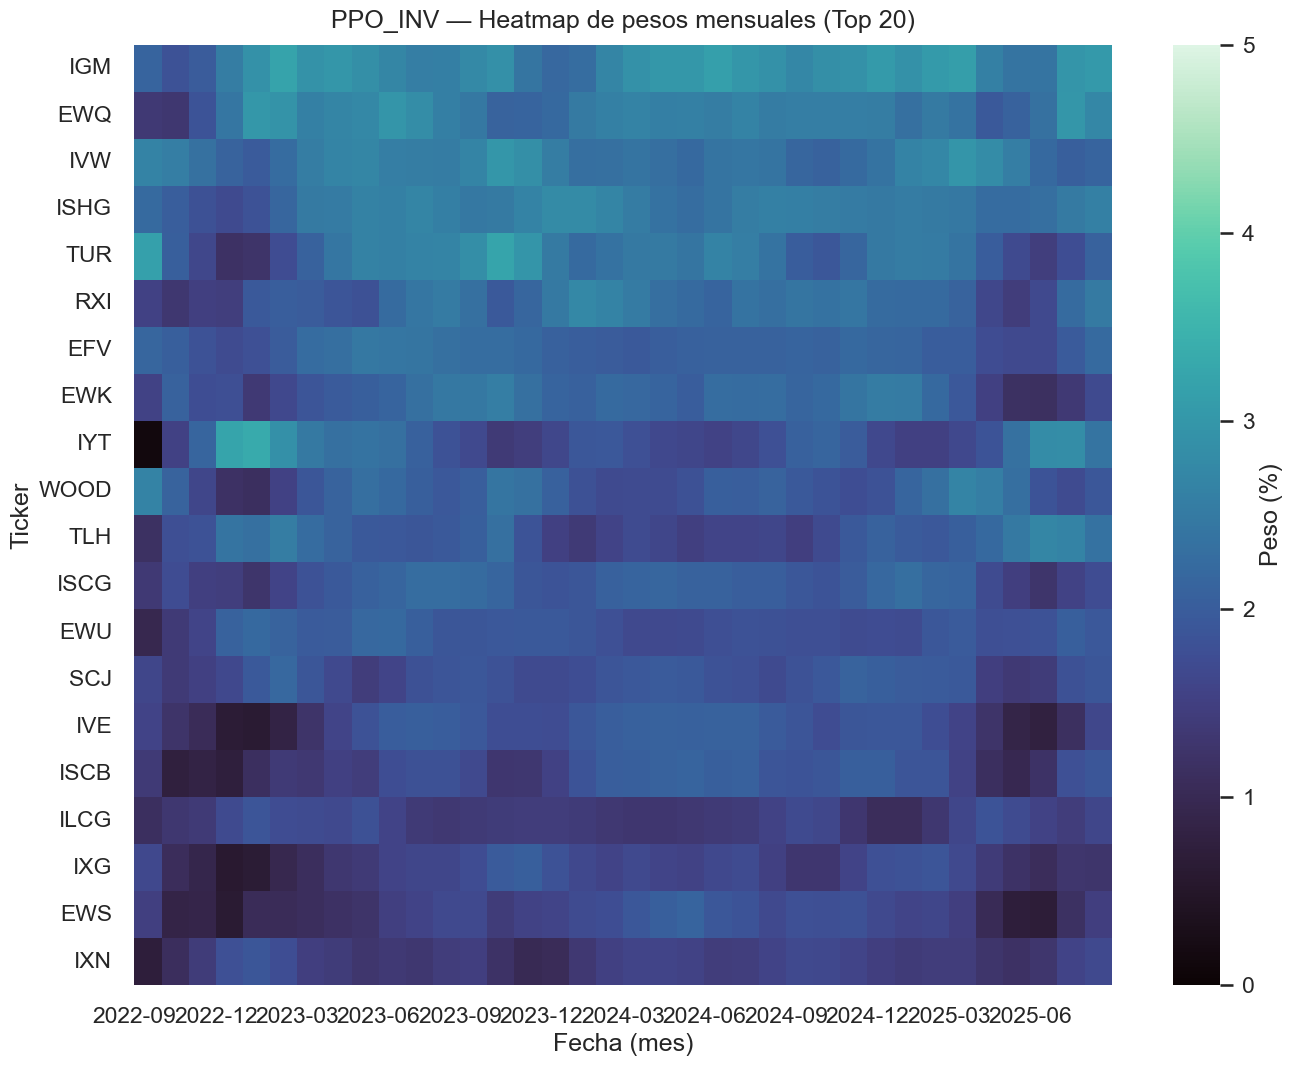

In [29]:
# =========================================================
# HEATMAP DE PESOS (PPO_INV)
# - Agrega a frecuencia mensual (media mensual)
# - Suaviza con media móvil de 3 meses
# - Top-N por peso medio
# - Eje X con etiquetas trimestrales
# =========================================================

# Pesos cacheados (0..1) y a %
W = STRATEGIE_STORE["PPO_INV"]["positions"]  # index=fechas diarias, cols=tickers
Wp = (W * 100.0).clip(lower=0)

# Agregación temporal mensual (media del mes)
Wp_m = Wp.resample("M").mean()

# Suavizado: media móvil 3M (para quitar ruido)
Wp_smooth = Wp_m.rolling(3, min_periods=1).mean()

# Selección de columnas: Top-N por peso medio en el periodo
TOP_N = 20
top_cols = Wp_smooth.mean(axis=0).sort_values(ascending=False).head(TOP_N).index

# Matriz final: filas=tickers, columnas=meses (YYYY-MM)
H = Wp_smooth[top_cols].T
H.columns = [c.strftime("%Y-%m") for c in H.columns]

# Escala de color robusta (evita que un outlier queme el mapa)
vmax = np.nanpercentile(H.values, 98)  # percentil 98
vmax = max(vmax, 5)                    # al menos 5% para contraste

# Plot
sns.set_theme(style="white", context="talk")
fig_h, ax_h = plt.subplots(figsize=(14, 0.45*TOP_N + 2), facecolor="white")

hm = sns.heatmap(
    H,
    ax=ax_h,
    cmap="mako",
    cbar_kws={"label": "Peso (%)"},
    vmin=0, vmax=vmax
)

ax_h.set_title(f"PPO_INV — Heatmap de pesos mensuales (Top {TOP_N})", pad=12)
ax_h.set_xlabel("Fecha (mes)")
ax_h.set_ylabel("Ticker")

# Etiquetas del eje X espaciadas (trimestrales aprox.)
xticks = np.arange(0, H.shape[1], max(1, H.shape[1] // 12))  # ~12 etiquetas
ax_h.set_xticks(xticks)
ax_h.set_xticklabels([H.columns[i] for i in xticks], rotation=0, ha="center")

plt.tight_layout()
plt.savefig(OUT_DIR / "ppo_heatmap_pesos_mensual.png", dpi=180, facecolor="white", transparent=False)
plt.show()


### Muestra cómo evoluciona la proporción de renta variable vs renta fija a lo largo del tiempo.

C:\Users\alons\AppData\Local\Temp\ipykernel_8980\2012129533.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  alloc = alloc.rolling(21, min_periods=5).mean().fillna(method="bfill")


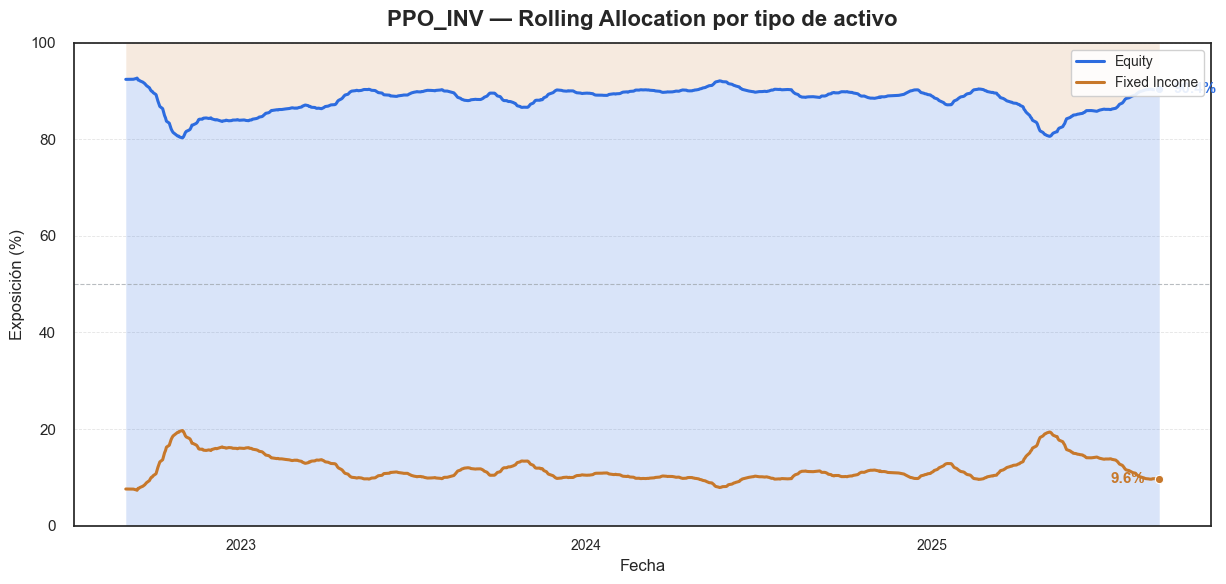

In [31]:
# Datos base
W = STRATEGIE_STORE["PPO_INV"]["positions"]
types = exposures.get("type_sector", {})

equity_cols = [t for t, tp in types.items() if tp == "Equity" and t in W.columns]
bond_cols   = [t for t, tp in types.items() if tp == "FixedIncome" and t in W.columns]

alloc = pd.DataFrame({
    "Equity": W[equity_cols].sum(axis=1),
    "Fixed Income": W[bond_cols].sum(axis=1)
}).clip(lower=0)

# Suavizado (21 días) y normalización a %
alloc = alloc.rolling(21, min_periods=5).mean().fillna(method="bfill")
alloc = (alloc.div(alloc.sum(axis=1), axis=0) * 100.0).clip(0, 100)

# Series finales
eq = alloc["Equity"]
bd = 100.0 - eq
idx = eq.index

# Estilo visual
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(12.5, 6), facecolor="white")

# Paleta
c_eq = "#2D6CDF"   # azul
c_bd = "#C7782B"   # ámbar

# Áreas
ax.fill_between(idx, 0,  eq,       color=c_eq, alpha=0.18, linewidth=0)
ax.fill_between(idx, eq, 100.0,    color=c_bd, alpha=0.15, linewidth=0)

# Líneas principales
ax.plot(idx, eq, color=c_eq, linewidth=2.2, label="Equity")
ax.plot(idx, bd, color=c_bd, linewidth=2.2, label="Fixed Income")

# Línea de equilibrio 50%
ax.axhline(50, color="#9aa0a6", linestyle="--", linewidth=0.8, alpha=0.7)

# Formato ejes y rejilla
ax.set_title("PPO_INV — Rolling Allocation por tipo de activo", fontsize=16, pad=12, weight="bold")
ax.set_ylabel("Exposición (%)"); ax.set_xlabel("Fecha")
ax.set_ylim(0, 100)

# Eje X: años (major) + meses (minor)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3,6,9,12]))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='x', which='minor', length=0)

# Rejilla
ax.grid(True, axis="y", linestyle="--", linewidth=0.6, color="#d9d9d9", alpha=0.7)

# Anotación del último valor de cada curva
for series, color, off in [(eq, c_eq, 10), (bd, c_bd, -10)]:
    x_last, y_last = series.index[-1], series.iloc[-1]
    ax.plot(x_last, y_last, "o", color=color, markersize=6, markeredgecolor="white", markeredgewidth=0.8)
    ax.annotate(f"{y_last:.1f}%", xy=(x_last, y_last), xytext=(off, 0),
                textcoords="offset points", va="center", ha="left" if off>0 else "right",
                fontsize=11, color=color, fontweight="bold")

# Leyenda
leg = ax.legend(loc="upper right", frameon=True, title="", fontsize=10)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig(OUT_DIR / "ppo_rolling_allocation_equity_bonds_premium.png",
            dpi=200, facecolor="white", transparent=False)
plt.show()
